# Header files

In [1]:
# !pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

# Data import

#### Patients data import

In [2]:
Main_data = pd.read_csv("dataset_diabetes/diabetic_data.csv",
                       sep=",",
                       header=0)

In [3]:
Main_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
Main_data.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [5]:
print("Total data point and features :",Main_data.shape)
print("Total patients data : ",Main_data['patient_nbr'].unique().shape[0])

Total data point and features : (101766, 50)
Total patients data :  71518


#### Mapping list

In [6]:
admission_type_mapping = pd.read_csv("dataset_diabetes/IDs_mapping.csv",
                                    sep=",",
                                    header=0,
                                    nrows=8)

In [7]:
discharge_disposition_mapping = pd.read_csv("dataset_diabetes/IDs_mapping.csv",
                                            sep=",",
                                            header=0,
                                            nrows=30,
                                            skiprows = 10)

In [8]:
admission_source_mapping = pd.read_csv("dataset_diabetes/IDs_mapping.csv",
                                        sep=",",
                                        header=0,
                                        skiprows=42)

# Preprocessing

In [9]:
#Print how many values are missing if there is no missing value that column is not printed
for col in Main_data.columns:
    if Main_data[col].dtype == object:
        missing_count = Main_data[col][Main_data[col] == '?'].count()
        if missing_count!=0:
            print(col,"  ",missing_count)

race    2273
weight    98569
payer_code    40256
medical_specialty    49949
diag_1    21
diag_2    358
diag_3    1423


In [10]:
#These columns were removed
Main_data = Main_data.drop(['weight','payer_code','medical_specialty'], axis=1)

#In this rows were removed
Main_data['race'] = Main_data['race'].replace('?', np.nan)
Main_data['diag_1'] = Main_data['diag_1'].replace('?', np.nan)
Main_data['diag_2'] = Main_data['diag_2'].replace('?', np.nan)
Main_data['diag_3'] = Main_data['diag_3'].replace('?', np.nan)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(11, np.nan)
Main_data['gender'] = Main_data['gender'].replace('Unknown/Invalid', np.nan)

Main_data = Main_data.dropna()

In [11]:
print("Patients and features :",Main_data.shape)
print("Total unique patients data : ",Main_data['patient_nbr'].unique().shape[0])

Patients and features : (96446, 47)
Total unique patients data :  67580


In [12]:
# Main_data['readmitted'] = Main_data['readmitted'].replace(2,0)

## Feature reduction and encoding

#### encounter id and patrient number are preprocessed

#### race

In [13]:
Race_dictionary = {'AfricanAmerican':0, 'Asian':1, 'Caucasian':2, 'Hispanic':3, 'Other':4}
Main_data['race'] = Main_data['race'].apply(lambda x: Race_dictionary[x])

#### gender

In [14]:
gender_dictionary  = {'Female': 1, 'Male': 0,}
Main_data['gender'] = Main_data['gender'].apply(lambda x: gender_dictionary[x])

#### age

In [15]:
age_dictionary = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55,'[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
Main_data['age'] = Main_data['age'].apply(lambda x: age_dictionary[x])

#### weight  (removed)

#### admission_type_id

In [16]:
admission_type_mapping

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [17]:
# (1,2,7) , (5,6,8) are related
Main_data['admission_type_id'] = Main_data['admission_type_id'].replace(2,1)
Main_data['admission_type_id'] = Main_data['admission_type_id'].replace(7,1)
Main_data['admission_type_id'] = Main_data['admission_type_id'].replace(6,5)
Main_data['admission_type_id'] = Main_data['admission_type_id'].replace(8,5)

# Now classes are 1,3,4,5 so change 5 to 2 for better understanding
Main_data['admission_type_id'] = Main_data['admission_type_id'].replace(5,2)

#### Discharge ID

In [18]:
discharge_disposition_mapping

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpa...
5,6,Discharged/transferred to home with home healt...
6,7,Left AMA
7,8,Discharged/transferred to home under care of H...
8,9,Admitted as an inpatient to this hospital
9,10,Neonate discharged to another hospital for neo...


In [19]:
# (1,6,8,9,13) , (2,3,4,5,14,22,23) , (10,12,15,16,17) , (18,25,26) are similar
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(6,1)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(8,1)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(9,1)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(13,1)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(3,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(4,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(5,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(14,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(22,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(23,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(24,2)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(12,10)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(15,10)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(16,10)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(17,10)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(25,18)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(26,18)

#Now category are 1, 2, 7, 10, 11, 18, 19, 20, 27, 28 converting them into increasing order with 1
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(7,3)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(10,4)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(11,5)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(18,6)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(19,7)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(20,8)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(27,9)
Main_data['discharge_disposition_id'] = Main_data['discharge_disposition_id'].replace(28,10)

#### Admission source id

In [20]:
admission_source_mapping

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)
5,6,Transfer from another health care facility
6,7,Emergency Room
7,8,Court/Law Enforcement
8,9,Not Available
9,10,Transfer from critial access hospital


In [21]:
# (1,2,3) , (4,5,6,10,22,25) , (9,15,17,20,21) , (11,13,14) are similar
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(2,1)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(3,1)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(5,4)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(6,4)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(10,4)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(22,4)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(25,4)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(15,9)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(17,9)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(20,9)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(21,9)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(13,11)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(14,11)

# Now categories are 1, 4, 7, 8, 9, 11 converting them into increasing order with 1
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(7,2)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(8,3)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(9,5)
Main_data['admission_source_id'] = Main_data['admission_source_id'].replace(11,6)

#### time_in_hospital is in number and preprocessed

#### Payer code (removed)

#### Medical specialty (removed)

#### num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient are in numbers and processed

#### Diagnosis columns

In [24]:
Main_data['level1_diag1'] = Main_data['diag_1']
Main_data['level2_diag1'] = Main_data['diag_1']
Main_data['level1_diag2'] = Main_data['diag_2']
Main_data['level2_diag2'] = Main_data['diag_2']
Main_data['level1_diag3'] = Main_data['diag_3']
Main_data['level2_diag3'] = Main_data['diag_3']

Main_data.loc[Main_data['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
Main_data.loc[Main_data['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
Main_data.loc[Main_data['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
Main_data.loc[Main_data['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
Main_data.loc[Main_data['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
Main_data.loc[Main_data['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0

Main_data['level1_diag1'] = Main_data['level1_diag1'].astype(float)
Main_data['level2_diag1'] = Main_data['level2_diag1'].astype(float)
Main_data['level1_diag2'] = Main_data['level1_diag2'].astype(float)
Main_data['level2_diag2'] = Main_data['level2_diag2'].astype(float)
Main_data['level1_diag3'] = Main_data['level1_diag3'].astype(float)
Main_data['level2_diag3'] = Main_data['level2_diag3'].astype(float)

for index, row in Main_data.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        Main_data.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        Main_data.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        Main_data.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        Main_data.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        Main_data.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        Main_data.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        Main_data.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        Main_data.loc[index, 'level1_diag1'] = 8
    else:
        Main_data.loc[index, 'level1_diag1'] = 0
        
    if (row['level1_diag2'] >= 390 and row['level1_diag2'] < 460) or (np.floor(row['level1_diag2']) == 785):
        Main_data.loc[index, 'level1_diag2'] = 1
    elif (row['level1_diag2'] >= 460 and row['level1_diag2'] < 520) or (np.floor(row['level1_diag2']) == 786):
        Main_data.loc[index, 'level1_diag2'] = 2
    elif (row['level1_diag2'] >= 520 and row['level1_diag2'] < 580) or (np.floor(row['level1_diag2']) == 787):
        Main_data.loc[index, 'level1_diag2'] = 3
    elif (np.floor(row['level1_diag2']) == 250):
        Main_data.loc[index, 'level1_diag2'] = 4
    elif (row['level1_diag2'] >= 800 and row['level1_diag2'] < 1000):
        Main_data.loc[index, 'level1_diag2'] = 5
    elif (row['level1_diag2'] >= 710 and row['level1_diag2'] < 740):
        Main_data.loc[index, 'level1_diag2'] = 6
    elif (row['level1_diag2'] >= 580 and row['level1_diag2'] < 630) or (np.floor(row['level1_diag2']) == 788):
        Main_data.loc[index, 'level1_diag2'] = 7
    elif (row['level1_diag2'] >= 140 and row['level1_diag2'] < 240):
        Main_data.loc[index, 'level1_diag2'] = 8
    else:
        Main_data.loc[index, 'level1_diag2'] = 0
    
    if (row['level1_diag3'] >= 390 and row['level1_diag3'] < 460) or (np.floor(row['level1_diag3']) == 785):
        Main_data.loc[index, 'level1_diag3'] = 1
    elif (row['level1_diag3'] >= 460 and row['level1_diag3'] < 520) or (np.floor(row['level1_diag3']) == 786):
        Main_data.loc[index, 'level1_diag3'] = 2
    elif (row['level1_diag3'] >= 520 and row['level1_diag3'] < 580) or (np.floor(row['level1_diag3']) == 787):
        Main_data.loc[index, 'level1_diag3'] = 3
    elif (np.floor(row['level1_diag3']) == 250):
        Main_data.loc[index, 'level1_diag3'] = 4
    elif (row['level1_diag3'] >= 800 and row['level1_diag3'] < 1000):
        Main_data.loc[index, 'level1_diag3'] = 5
    elif (row['level1_diag3'] >= 710 and row['level1_diag3'] < 740):
        Main_data.loc[index, 'level1_diag3'] = 6
    elif (row['level1_diag3'] >= 580 and row['level1_diag3'] < 630) or (np.floor(row['level1_diag3']) == 788):
        Main_data.loc[index, 'level1_diag3'] = 7
    elif (row['level1_diag3'] >= 140 and row['level1_diag3'] < 240):
        Main_data.loc[index, 'level1_diag3'] = 8
    else:
        Main_data.loc[index, 'level1_diag3'] = 0
        
for index, row in Main_data.iterrows():
    if (row['level2_diag1'] >= 390 and row['level2_diag1'] < 399):
        Main_data.loc[index, 'level2_diag1'] = 1
    elif (row['level2_diag1'] >= 401 and row['level2_diag1'] < 415):
        Main_data.loc[index, 'level2_diag1'] = 2
    elif (row['level2_diag1'] >= 415 and row['level2_diag1'] < 460):
        Main_data.loc[index, 'level2_diag1'] = 3
    elif (np.floor(row['level2_diag1']) == 785):
        Main_data.loc[index, 'level2_diag1'] = 4
    elif (row['level2_diag1'] >= 460 and row['level2_diag1'] < 489):
        Main_data.loc[index, 'level2_diag1'] = 5
    elif (row['level2_diag1'] >= 490 and row['level2_diag1'] < 497):
        Main_data.loc[index, 'level2_diag1'] = 6
    elif (row['level2_diag1'] >= 500 and row['level2_diag1'] < 520):
        Main_data.loc[index, 'level2_diag1'] = 7
    elif (np.floor(row['level2_diag1']) == 786):
        Main_data.loc[index, 'level2_diag1'] = 8
    elif (row['level2_diag1'] >= 520 and row['level2_diag1'] < 530):
        Main_data.loc[index, 'level2_diag1'] = 9
    elif (row['level2_diag1'] >= 530 and row['level2_diag1'] < 544):
        Main_data.loc[index, 'level2_diag1'] = 10
    elif (row['level2_diag1'] >= 550 and row['level2_diag1'] < 554):
        Main_data.loc[index, 'level2_diag1'] = 11
    elif (row['level2_diag1'] >= 555 and row['level2_diag1'] < 580):
        Main_data.loc[index, 'level2_diag1'] = 12
    elif (np.floor(row['level2_diag1']) == 787):
        Main_data.loc[index, 'level2_diag1'] = 13
    elif (np.floor(row['level2_diag1']) == 250):
        Main_data.loc[index, 'level2_diag1'] = 14
    elif (row['level2_diag1'] >= 800 and row['level2_diag1'] < 1000):
        Main_data.loc[index, 'level2_diag1'] = 15
    elif (row['level2_diag1'] >= 710 and row['level2_diag1'] < 740):
        Main_data.loc[index, 'level2_diag1'] = 16
    elif (row['level2_diag1'] >= 580 and row['level2_diag1'] < 630):
        Main_data.loc[index, 'level2_diag1'] = 17
    elif (np.floor(row['level2_diag1']) == 788):
        Main_data.loc[index, 'level2_diag1'] = 18
    elif (row['level2_diag1'] >= 140 and row['level2_diag1'] < 240):
        Main_data.loc[index, 'level2_diag1'] = 19
    elif row['level2_diag1'] >= 240 and row['level2_diag1'] < 280 and (np.floor(row['level2_diag1']) != 250):
        Main_data.loc[index, 'level2_diag1'] = 20
    elif (row['level2_diag1'] >= 680 and row['level2_diag1'] < 710) or (np.floor(row['level2_diag1']) == 782):
        Main_data.loc[index, 'level2_diag1'] = 21
    elif (row['level2_diag1'] >= 290 and row['level2_diag1'] < 320):
        Main_data.loc[index, 'level2_diag1'] = 22
    else:
        Main_data.loc[index, 'level2_diag1'] = 0
        
    if (row['level2_diag2'] >= 390 and row['level2_diag2'] < 399):
        Main_data.loc[index, 'level2_diag2'] = 1
    elif (row['level2_diag2'] >= 401 and row['level2_diag2'] < 415):
        Main_data.loc[index, 'level2_diag2'] = 2
    elif (row['level2_diag2'] >= 415 and row['level2_diag2'] < 460):
        Main_data.loc[index, 'level2_diag2'] = 3
    elif (np.floor(row['level2_diag2']) == 785):
        Main_data.loc[index, 'level2_diag2'] = 4
    elif (row['level2_diag2'] >= 460 and row['level2_diag2'] < 489):
        Main_data.loc[index, 'level2_diag2'] = 5
    elif (row['level2_diag2'] >= 490 and row['level2_diag2'] < 497):
        Main_data.loc[index, 'level2_diag2'] = 6
    elif (row['level2_diag2'] >= 500 and row['level2_diag2'] < 520):
        Main_data.loc[index, 'level2_diag2'] = 7
    elif (np.floor(row['level2_diag2']) == 786):
        Main_data.loc[index, 'level2_diag2'] = 8
    elif (row['level2_diag2'] >= 520 and row['level2_diag2'] < 530):
        Main_data.loc[index, 'level2_diag2'] = 9
    elif (row['level2_diag2'] >= 530 and row['level2_diag2'] < 544):
        Main_data.loc[index, 'level2_diag2'] = 10
    elif (row['level2_diag2'] >= 550 and row['level2_diag2'] < 554):
        Main_data.loc[index, 'level2_diag2'] = 11
    elif (row['level2_diag2'] >= 555 and row['level2_diag2'] < 580):
        Main_data.loc[index, 'level2_diag2'] = 12
    elif (np.floor(row['level2_diag2']) == 787):
        Main_data.loc[index, 'level2_diag2'] = 13
    elif (np.floor(row['level2_diag2']) == 250):
        Main_data.loc[index, 'level2_diag2'] = 14
    elif (row['level2_diag2'] >= 800 and row['level2_diag2'] < 1000):
        Main_data.loc[index, 'level2_diag2'] = 15
    elif (row['level2_diag2'] >= 710 and row['level2_diag2'] < 740):
        Main_data.loc[index, 'level2_diag2'] = 16
    elif (row['level2_diag2'] >= 580 and row['level2_diag2'] < 630):
        Main_data.loc[index, 'level2_diag2'] = 17
    elif (np.floor(row['level2_diag2']) == 788):
        Main_data.loc[index, 'level2_diag2'] = 18
    elif (row['level2_diag2'] >= 140 and row['level2_diag2'] < 240):
        Main_data.loc[index, 'level2_diag2'] = 19
    elif row['level2_diag2'] >= 240 and row['level2_diag2'] < 280 and (np.floor(row['level2_diag2']) != 250):
        Main_data.loc[index, 'level2_diag2'] = 20
    elif (row['level2_diag2'] >= 680 and row['level2_diag2'] < 710) or (np.floor(row['level2_diag2']) == 782):
        Main_data.loc[index, 'level2_diag2'] = 21
    elif (row['level2_diag2'] >= 290 and row['level2_diag2'] < 320):
        Main_data.loc[index, 'level2_diag2'] = 22
    else:
        Main_data.loc[index, 'level2_diag2'] = 0
        
        
    if (row['level2_diag3'] >= 390 and row['level2_diag3'] < 399):
        Main_data.loc[index, 'level2_diag3'] = 1
    elif (row['level2_diag3'] >= 401 and row['level2_diag3'] < 415):
        Main_data.loc[index, 'level2_diag3'] = 2
    elif (row['level2_diag3'] >= 415 and row['level2_diag3'] < 460):
        Main_data.loc[index, 'level2_diag3'] = 3
    elif (np.floor(row['level2_diag3']) == 785):
        Main_data.loc[index, 'level2_diag3'] = 4
    elif (row['level2_diag3'] >= 460 and row['level2_diag3'] < 489):
        Main_data.loc[index, 'level2_diag3'] = 5
    elif (row['level2_diag3'] >= 490 and row['level2_diag3'] < 497):
        Main_data.loc[index, 'level2_diag3'] = 6
    elif (row['level2_diag3'] >= 500 and row['level2_diag3'] < 520):
        Main_data.loc[index, 'level2_diag3'] = 7
    elif (np.floor(row['level2_diag3']) == 786):
        Main_data.loc[index, 'level2_diag3'] = 8
    elif (row['level2_diag3'] >= 520 and row['level2_diag3'] < 530):
        Main_data.loc[index, 'level2_diag3'] = 9
    elif (row['level2_diag3'] >= 530 and row['level2_diag3'] < 544):
        Main_data.loc[index, 'level2_diag3'] = 10
    elif (row['level2_diag3'] >= 550 and row['level2_diag3'] < 554):
        Main_data.loc[index, 'level2_diag3'] = 11
    elif (row['level2_diag3'] >= 555 and row['level2_diag3'] < 580):
        Main_data.loc[index, 'level2_diag3'] = 12
    elif (np.floor(row['level2_diag3']) == 787):
        Main_data.loc[index, 'level2_diag3'] = 13
    elif (np.floor(row['level2_diag3']) == 250):
        Main_data.loc[index, 'level2_diag3'] = 14
    elif (row['level2_diag3'] >= 800 and row['level2_diag3'] < 1000):
        Main_data.loc[index, 'level2_diag3'] = 15
    elif (row['level2_diag3'] >= 710 and row['level2_diag3'] < 740):
        Main_data.loc[index, 'level2_diag3'] = 16
    elif (row['level2_diag3'] >= 580 and row['level2_diag3'] < 630):
        Main_data.loc[index, 'level2_diag3'] = 17
    elif (np.floor(row['level2_diag3']) == 788):
        Main_data.loc[index, 'level2_diag3'] = 18
    elif (row['level2_diag3'] >= 140 and row['level2_diag3'] < 240):
        Main_data.loc[index, 'level2_diag3'] = 19
    elif row['level2_diag3'] >= 240 and row['level2_diag3'] < 280 and (np.floor(row['level2_diag3']) != 250):
        Main_data.loc[index, 'level2_diag3'] = 20
    elif (row['level2_diag3'] >= 680 and row['level2_diag3'] < 710) or (np.floor(row['level2_diag3']) == 782):
        Main_data.loc[index, 'level2_diag3'] = 21
    elif (row['level2_diag3'] >= 290 and row['level2_diag3'] < 320):
        Main_data.loc[index, 'level2_diag3'] = 22
    else:
        Main_data.loc[index, 'level2_diag3'] = 0

#### number of diagnoses preprocessed

#### Glucose serum

In [25]:
Glucose_dictionary = {'None':10, '>300':1, 'Norm':0, '>200':1}
Main_data['max_glu_serum'] = Main_data['max_glu_serum'].apply(lambda x: Glucose_dictionary[x])

#### Haempglobin A1c test

In [26]:
haemoglobin_dictionary = {'None':10, '>7':1, '>8':1, 'Norm':0}
Main_data['A1Cresult'] = Main_data['A1Cresult'].apply(lambda x: haemoglobin_dictionary[x])

#### 24 medicine processing

In [27]:
allcol = Main_data.columns
dose_dictionary  = {'Steady': 0, 'Up': 1, 'Down': 1, 'No' : 0}
for i in range(21,44):
    Main_data[allcol[i]] = Main_data[allcol[i]].apply(lambda x: dose_dictionary[x])

#### medicine changed

In [28]:
change_dictionary = {'No':0, 'Ch':1}
Main_data['change'] = Main_data['change'].apply(lambda x: change_dictionary[x])

#### diabetes medicine

In [29]:
diabetesMed_dictionary = {'No':0, 'Yes':1}
Main_data['diabetesMed'] = Main_data['diabetesMed'].apply(lambda x: diabetesMed_dictionary[x])

#### readmisson

In [30]:
readmitted_dictionary = { 'NO':0, '<30':1, '>30':2}
Main_data['readmitted'] = Main_data['readmitted'].apply(lambda x: readmitted_dictionary[x])

In [31]:
Main_data.dtypes

encounter_id                  int64
patient_nbr                   int64
race                          int64
gender                        int64
age                           int64
admission_type_id             int64
discharge_disposition_id    float64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   int64
acetohexamide                 int64
glipizide                   

### Save processed file (Main_data panda dataframe)

In [32]:
Main_data.to_csv("Main_data.csv")

# Data Description

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0,0,'No readmission'),
 Text(0,0,'Readmission within 30 days'),
 Text(0,0,'Readmission after 30 days')]

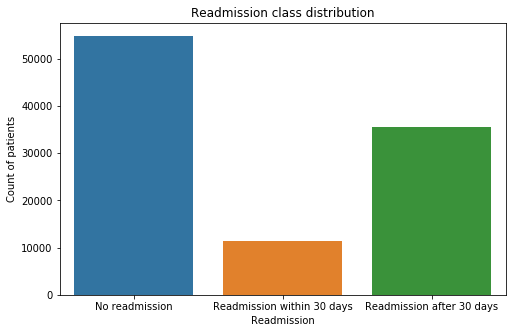

In [41]:
fig = plt.figure(figsize=(8,5))
ax = sns.countplot(Main_data['readmitted'])
ax.set_title('Readmission class distribution')
ax.set_xlabel('Readmission')
ax.set_ylabel('Count of patients')
ax.set_xticklabels(['No readmission','Readmission within 30 days','Readmission after 30 days'])

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0,0.5,'Count of patients')

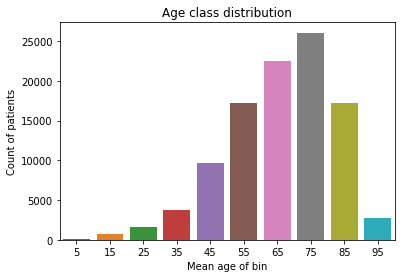

In [43]:
ax = sns.countplot(Main_data['age'])
ax.set_title('Age class distribution')
ax.set_xlabel('Mean age of bin')
ax.set_ylabel('Count of patients')

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0,0.5,'Count of patients'), Text(0.5,0,'Time in Hospital')]

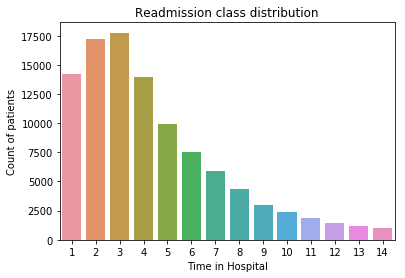

In [44]:
ax = sns.countplot(Main_data['time_in_hospital'])
ax.set_title('Readmission class distribution')
ax.set(xlabel='Time in Hospital', ylabel='Count of patients')

Text(0.5,1,'Time in hospital VS Readmission')

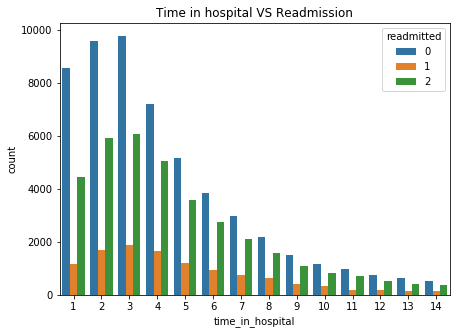

In [75]:
fig = plt.figure(figsize=(7,5))

sns.countplot(x = Main_data['time_in_hospital'], 
              hue = Main_data['readmitted']).set_title('Time in hospital VS Readmission')

Text(0.5,1,'Age of Patient VS. Readmission')

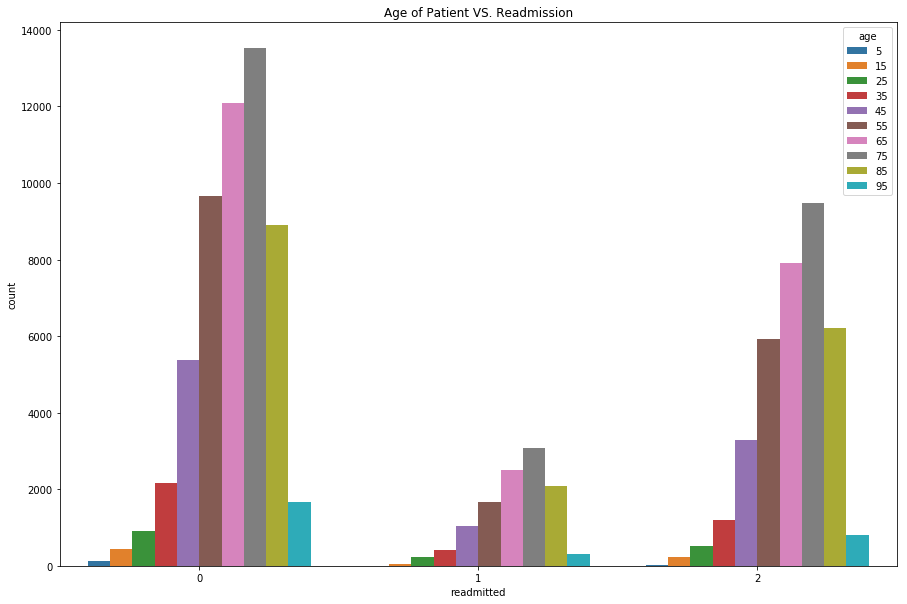

In [50]:
fig = plt.figure(figsize=(15,10))

sns.countplot(hue = Main_data['age'], 
              x = Main_data['readmitted']).set_title('Age of Patient VS. Readmission')

[Text(0,0,'Other'),
 Text(0,0,'Caucasian'),
 Text(0,0,'African American'),
 Text(0,0,'Asian'),
 Text(0,0,'Hipanic')]

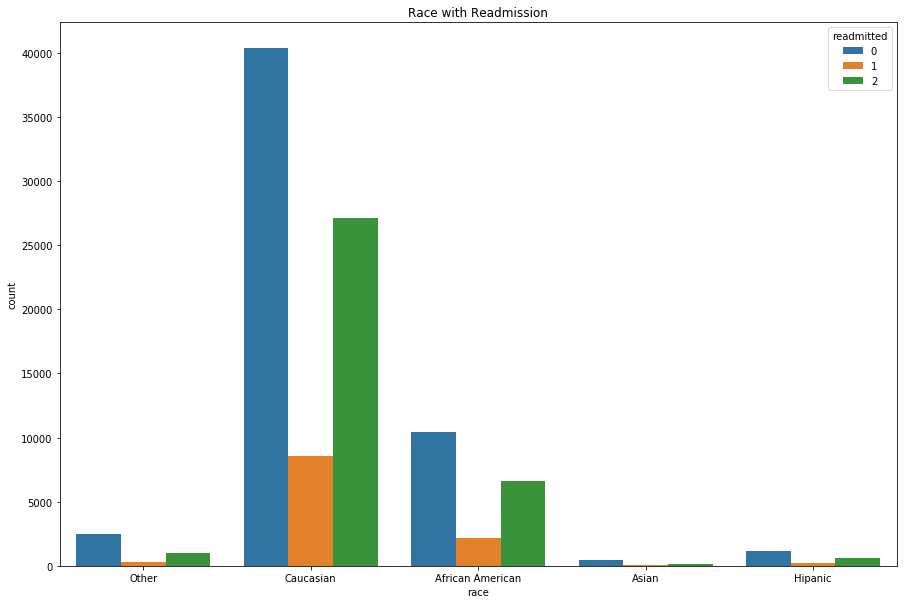

In [59]:
fig = plt.figure(figsize=(15,10))

ax = sns.countplot(x = Main_data['race'], 
              hue = Main_data['readmitted'])

ax.set_title('Race with Readmission')

ax.set_xticklabels(['Other','Caucasian','African American','Asian','Hipanic'])

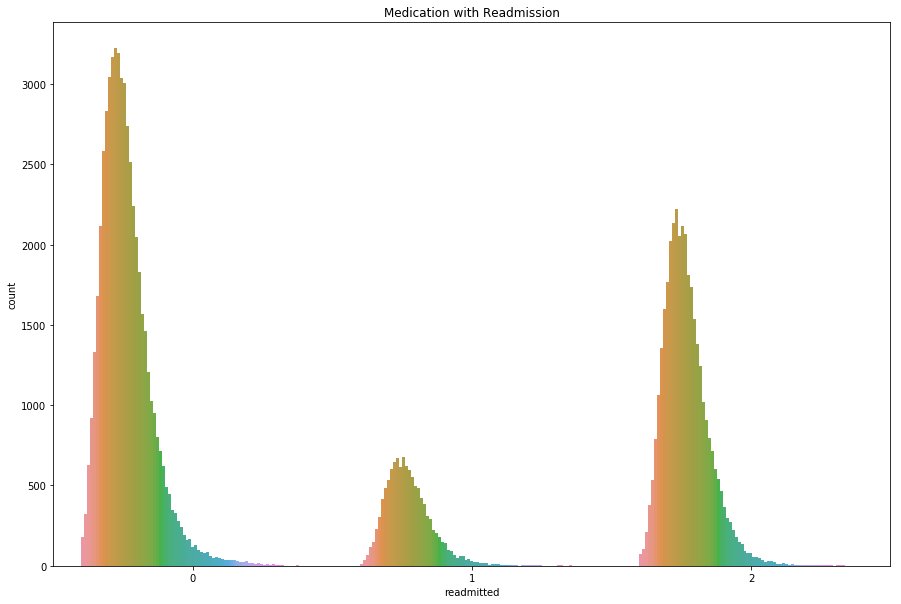

In [63]:
fig = plt.figure(figsize=(15,10))

ax = sns.countplot(hue = Main_data['num_medications'], 
                   x = Main_data['readmitted'])

ax.set_title('Medication with Readmission')
ax.get_legend().remove()

[Text(0,0,'Test not taken'),
 Text(0,0,'Normal level'),
 Text(0,0,'Abnormal level')]

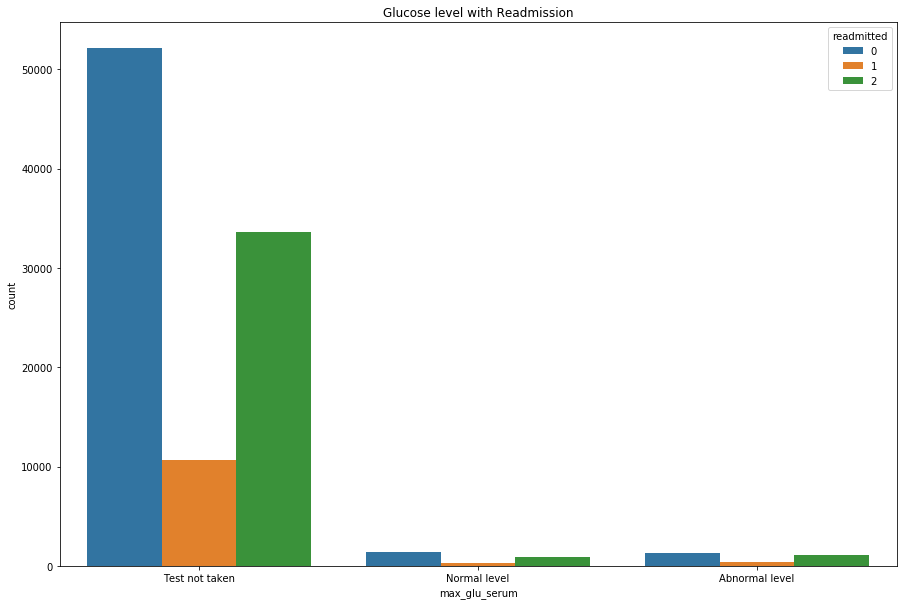

In [66]:
fig = plt.figure(figsize=(15,10))

ax = sns.countplot(x = Main_data['max_glu_serum'], 
                   hue = Main_data['readmitted'])

ax.set_title('Glucose level with Readmission')

ax.set_xticklabels(['Test not taken','Normal level','Abnormal level'])

Text(0.5,1,'Haemoglobin glucose test with Readmission')

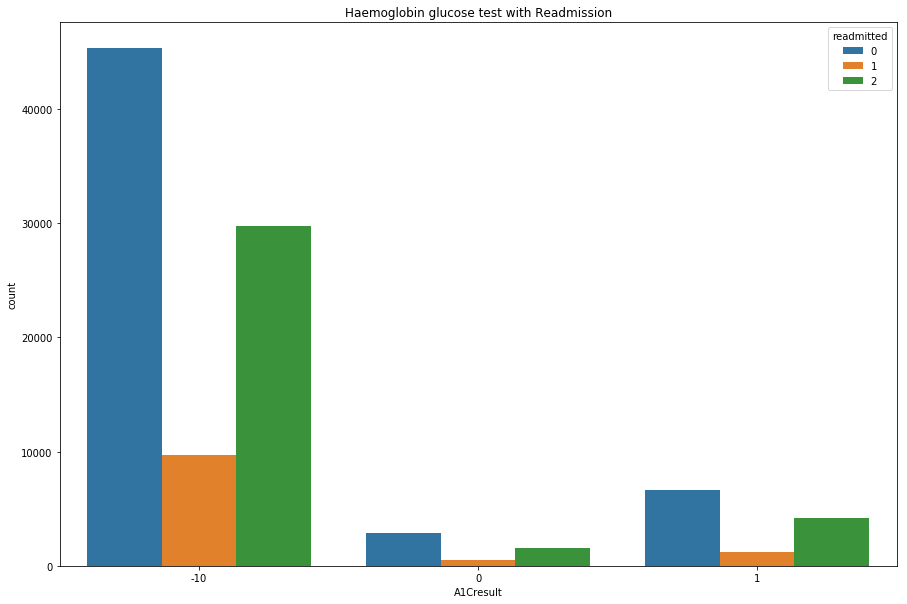

In [60]:
fig = plt.figure(figsize=(15,10))

ax = sns.countplot(x = Main_data['A1Cresult'], 
                   hue = Main_data['readmitted'])

ax.set_title('Haemoglobin glucose test with Readmission')

# ax.set_xticklabels(['Test not taken','Normal level','Abnormal level'])

Text(0.5,1,'Correlation heatmap')

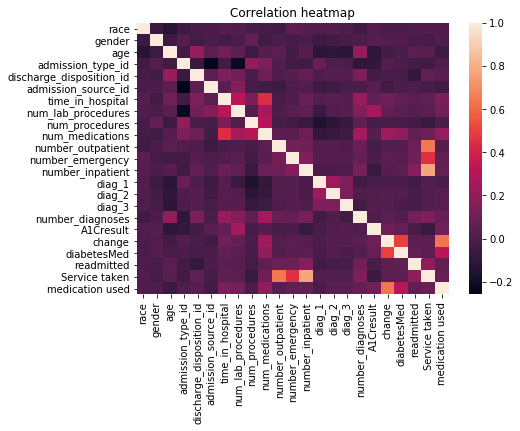

In [58]:
fig = plt.figure(figsize=(7,5))

ax = sns.heatmap(df.drop(columns=['max_glu_serum']).corr())
ax.set_title('Correlation heatmap')

In [2]:
Main_data = pd.read_csv("Main_data.csv", sep=",")
Main_data = Main_data.drop(['Unnamed: 0'], axis=1)

# Feature engineering 

In [3]:
Main_data['service_taken'] = Main_data['number_outpatient'] + Main_data['number_inpatient'] + Main_data['number_emergency']

In [4]:
#For this Up and down is taken as 1 and other as 0
Main_data['medication_used']=0
for name in Main_data.columns[21:44]:
    Main_data['medication_used'] = Main_data['medication_used'] + Main_data[name]
    
Main_data['medication_used'].value_counts()

0    70142
1    24922
2     1271
3      106
4        5
Name: medication_used, dtype: int64

In [5]:
log_transform = ['service_taken', 'number_outpatient', 'number_inpatient', 'number_emergency']

for col in log_transform:
    Main_data[col+'_log1p'] = np.log1p(Main_data[col])

In [6]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','medication_used')]

for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    Main_data[name] = Main_data[inter[0]] * Main_data[inter[1]]

In [7]:
#not feature engineer
age_dict = {5:1, 15:2, 25:3, 35:4, 45:5, 55:6, 65:7, 75:8, 85:9, 95:10, 105:11}
Main_data['age'] = Main_data['age'].apply(lambda x: age_dict[x])

Main_data['readmitted'] = Main_data['readmitted'].replace(2,0)

In [8]:
Main_data.shape

(96446, 68)

## Outlier removal

In [9]:
df2 = Main_data.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

In [10]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

numerics = ['num_procedures',
 'num_medications',
 'time_in_hospital',
 'service_taken_log1p',
 'number_inpatient_log1p',
 'num_lab_procedures',
 'number_diagnoses',
 'number_emergency_log1p',
 'medication_used',
 'number_outpatient_log1p']

df2[numerics] = standardize(df2[numerics])
import scipy as sp
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [11]:
df2['level1_diag1'] = df2['level1_diag1'].astype('object')
df_pd = pd.get_dummies(df2, columns=['gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult', 'level1_diag1'], drop_first = False)
just_dummies = pd.get_dummies(df_pd['race'])
df_pd = pd.concat([df_pd, just_dummies], axis=1)      
df_pd.drop(['race'], inplace=True, axis=1)

### Save processed file (Main_data panda dataframe)

In [12]:
df_pd.to_csv("Main_data.csv")

# Load Saved file   (To head start)

In [2]:
df_pd = pd.read_csv("Main_data.csv", sep=",")
df_pd = df_pd.drop(['Unnamed: 0'], axis=1)

# Selected features

In [3]:
feature_set = ['age', 'time_in_hospital', 'num_procedures', 'num_medications',  
            'number_outpatient_log1p', 'number_emergency_log1p', 'number_inpatient_log1p','number_diagnoses',
            'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
            'pioglitazone', 'rosiglitazone', 'acarbose', 'tolazamide', 'insulin', 'glyburide-metformin',
            '0','1','2','3','4', 'gender_1', 
            'admission_type_id_2','admission_type_id_3', 
            'discharge_disposition_id_2.0','discharge_disposition_id_3.0', 'discharge_disposition_id_4.0','discharge_disposition_id_6.0',
            'admission_source_id_2', 'admission_source_id_4', 'admission_source_id_5',
            'max_glu_serum_0', 'max_glu_serum_1', 
            'A1Cresult_0', 'A1Cresult_1', 
            'level1_diag1_1.0', 'level1_diag1_2.0', 'level1_diag1_3.0', 'level1_diag1_4.0',
            'level1_diag1_5.0','level1_diag1_6.0', 'level1_diag1_7.0', 'level1_diag1_8.0']

In [4]:
df_pd.columns

Index(['encounter_id', 'patient_nbr', 'age', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       ...
       'level1_diag1_4.0', 'level1_diag1_5.0', 'level1_diag1_6.0',
       'level1_diag1_7.0', 'level1_diag1_8.0', '0', '1', '2', '3', '4'],
      dtype='object', length=101)

## Divide by age

In [5]:
Agedf1 = df_pd[df_pd['age'] < 4]
Agedf2 = df_pd.loc[(df_pd['age'] > 3) & (df_pd['age'] < 8)]
Agedf3 = df_pd[df_pd['age'] > 7]

X_1 = Agedf1[feature_set]
Y_1 = Agedf1['readmitted']

X_2 = Agedf2[feature_set]
Y_2 = Agedf2['readmitted']

X_3 = Agedf3[feature_set]
Y_3 = Agedf3['readmitted']

# Class imbalance

In [18]:
def apply_SMOTE(X, Y):
    sm = SMOTE(sampling_strategy='auto',
            random_state=None,
            k_neighbors=5,
            n_jobs=None) 
    SMOTE_X, SMOTE_Y = sm.fit_sample(X, Y.ravel()) 
    X_train, X_test, y_train, y_test = train_test_split(SMOTE_X, SMOTE_Y, test_size=0.20, random_state=0)
    return X_train, X_test, y_train, y_test

# Model Comparison 

In [54]:
def compare_models(X_train_res, y_train_res, X_test, y_test, verbose=False, model_include=None):

    
    if model_include==None:
        models =[
                ('LogReg', LogisticRegression(C= 10, multi_class='ovr', penalty='l2', solver='saga')), 
                ('GNB', GaussianNB()),
                ('Tree', DecisionTreeClassifier(criterion='entropy', max_features='auto')),
                ('RF', RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators=50)),
                ('XGB', XGBClassifier(eta = 0.3, objective = 'binary:logistic',eval_metric = 'auc', seed = 7,reg_alpha = 1)),
                ('KNN', KNeighborsClassifier())                
                ]
    else:
        models = []
        for mod in model_include:
            models.append((mod, models_dict[mod]))

    results = []
    names = []
    dfs = []
    scoring = {'accuracy': 'accuracy', 
            'precision_weighted':'precision_weighted', 
            'recall_weighted':'recall_weighted', 
            'f1_weighted':'f1_weighted', 
            'roc_auc':'roc_auc', 
            'matthews_corrcoef': make_scorer(matthews_corrcoef)}


    for name, model in models:
            

            #k fold cross validation
            kfold = model_selection.KFold(n_splits=5, 
                                        shuffle=True, 
                                        random_state=100)


            cv_results = model_selection.cross_validate(model, 
                                                        X_train_res, y_train_res, 
                                                        cv=kfold, 
                                                        scoring=scoring)
            results.append(cv_results)
            names.append(name)

            #data fitting on model
            clf = model.fit(X_train_res, y_train_res)

            #make predictions and confusion matrix
            y_pred = clf.predict(X_test)

            if verbose:
                print(name)
                print(classification_report(y_test, y_pred))
                print(confusion_matrix(y_test, y_pred))
                print(matthews_corrcoef(y_test, y_pred))
                print()


            this_df = pd.DataFrame(cv_results)
            this_df['model'] = name
            dfs.append(this_df)

    final_df = pd.concat(dfs, ignore_index=True)
    return final_df

In [51]:
def graphs_matrice(mat_list, final_df):
    grouping = final_df.groupby(by='model', axis=0, as_index=True, sort=False)

    matrices = ['fit_time', 'score_time', 'test_accuracy', 'test_precision_weighted',
            'test_recall_weighted', 'test_f1_weighted', 'test_roc_auc',
            'test_matthews_corrcoef', 'model']
    
    matrices_to_be = [matrices[i] for i in mat_list]
    
    sns.set(font_scale=1)
    
    for mat in matrices_to_be:
        ax = sns.boxplot(x="model", y=mat, hue="model", data=final_df, palette="Set3")
        ax.get_legend().remove()
        plt.show()

Text(0.5,1,'Comparison of Model by Classification Metric   (Age group (70-100))')

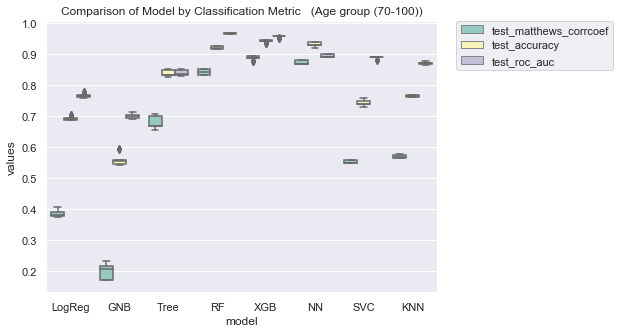

In [62]:
final_df = final_df3
bootstraps = []
for model in list(set(final_df.model.values)):
    model_df = final_df.loc[final_df.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] 

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

results_long_nofit = results_long_nofit[results_long_nofit['metrics'].isin(['test_accuracy','test_matthews_corrcoef','test_roc_auc'])]

plt.figure(figsize=(7, 5))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3",order=['LogReg','GNB','Tree','RF','XGB','NN','SVC','KNN'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric   (Age group (70-100))')

## 0-30

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Sam

LogReg
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       240
           1       0.77      0.87      0.82       232

    accuracy                           0.81       472
   macro avg       0.81      0.81      0.81       472
weighted avg       0.81      0.81      0.81       472

[[180  60]
 [ 30 202]]
0.6244013415344685

GNB
              precision    recall  f1-score   support

           0       0.94      0.37      0.53       240
           1       0.60      0.97      0.74       232

    accuracy                           0.67       472
   macro avg       0.77      0.67      0.64       472
weighted avg       0.77      0.67      0.63       472

[[ 89 151]
 [  6 226]]
0.43013031884557956

Tree
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       240
           1       0.89      0.94      0.91       232

    accuracy                           0.91       472
   macro avg       0.91  

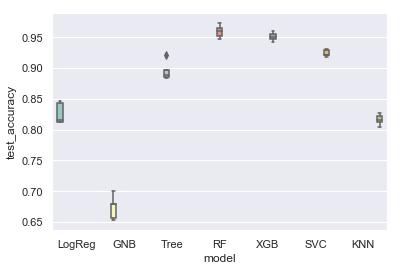

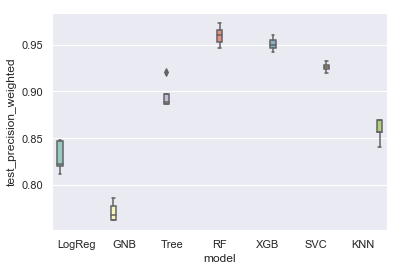

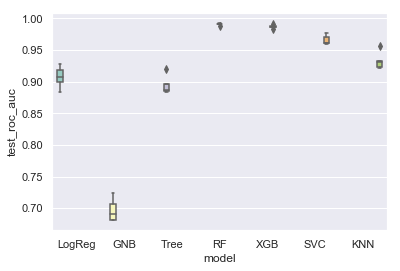

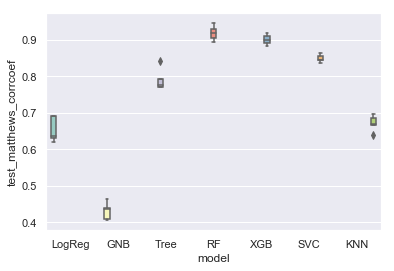

In [45]:
# for 0-30
X_train, X_test, y_train, y_test = apply_SMOTE(X_1, Y_1)
final_df1 = compare_models(X_train, y_train, X_test, y_test, True)
graphs_matrice([2,3,6,7], final_df1)

## 30-70

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Sam

LogReg
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      5939
           1       0.73      0.72      0.72      5880

    accuracy                           0.73     11819
   macro avg       0.73      0.73      0.73     11819
weighted avg       0.73      0.73      0.73     11819

[[4332 1607]
 [1636 4244]]
0.45120092089571273

GNB
              precision    recall  f1-score   support

           0       0.82      0.14      0.24      5939
           1       0.53      0.97      0.68      5880

    accuracy                           0.55     11819
   macro avg       0.67      0.55      0.46     11819
weighted avg       0.67      0.55      0.46     11819

[[ 821 5118]
 [ 181 5699]]
0.192881480120634

Tree
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      5939
           1       0.87      0.90      0.89      5880

    accuracy                           0.89     11819
   macro avg      

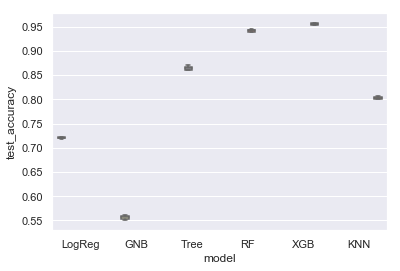

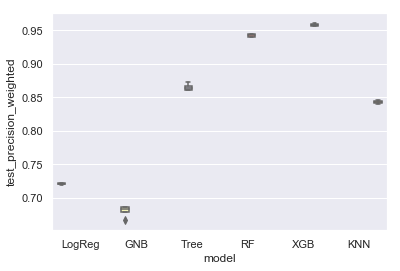

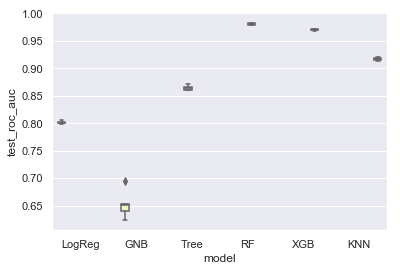

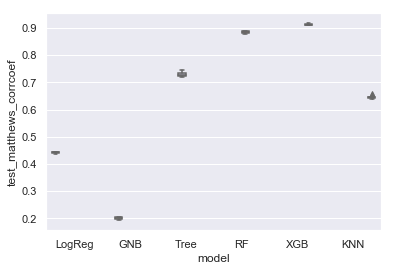

In [52]:
# for 30-70
X_train, X_test, y_train, y_test = apply_SMOTE(X_2, Y_2)
final_df2 = compare_models(X_train, y_train, X_test, y_test, True)
graphs_matrice([2,3,6,7], final_df2)

## 70-100

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Sam

LogReg
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      4758
           1       0.71      0.69      0.70      4806

    accuracy                           0.70      9564
   macro avg       0.70      0.70      0.70      9564
weighted avg       0.70      0.70      0.70      9564

[[3384 1374]
 [1503 3303]]
0.3985801961929653

GNB
              precision    recall  f1-score   support

           0       0.81      0.15      0.26      4758
           1       0.53      0.96      0.69      4806

    accuracy                           0.56      9564
   macro avg       0.67      0.56      0.47      9564
weighted avg       0.67      0.56      0.47      9564

[[ 733 4025]
 [ 176 4630]]
0.2002109320995982

Tree
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4758
           1       0.84      0.85      0.85      4806

    accuracy                           0.85      9564
   macro avg      

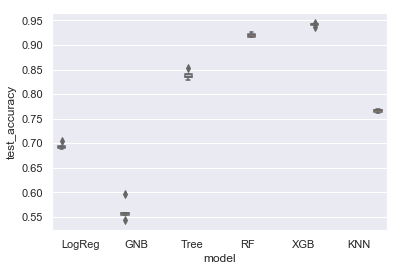

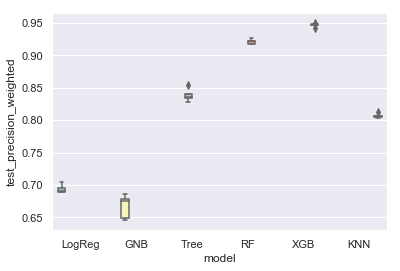

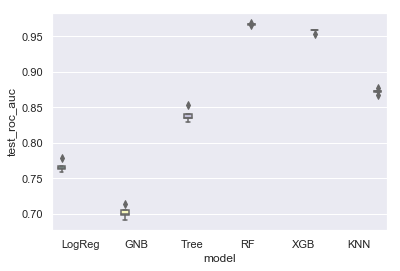

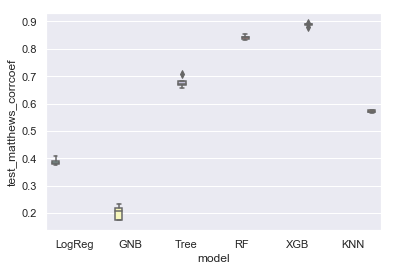

In [58]:
# for 70-100
X_train, X_test, y_train, y_test = apply_SMOTE(X_3, Y_3)
final_df3 = compare_models(X_train, y_train, X_test, y_test, True)
graphs_matrice([2,3,6,7], final_df3)

# Logistic regression

In [48]:
for i in str(LogisticRegression().__doc__).split('Parameters\n    ----------\n')[1].split('\n\n    Attributes\n')[0].replace('\n        ', '\n').splitlines():
    if " : " in i: 
        print(i)
        
 
def Run_LogisticRegression(X_train, y_train, X_test, y_test):
    parameters = {'penalty': ['l2'], 
                  'C': [1,10,100], 
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                  'multi_class': ['ovr']}
    
    model = LogisticRegression()
    
    clf = GridSearchCV(model, parameters, scoring=make_scorer(matthews_corrcoef))
    clf.fit(X_train, y_train)
    
    print("---Best parameters----")
    print(clf.best_params_)
    
    y_pred = clf.predict(X_test)

    print()
    print('Classification report')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                            labels=None,
                            sample_weight=None)
    
    sns.heatmap(heatmap_array)

    penalty : {'l1', 'l2', 'elasticnet', 'none'}, default='l2'
    dual : bool, default=False
    tol : float, default=1e-4
    C : float, default=1.0
    fit_intercept : bool, default=True
    intercept_scaling : float, default=1
    class_weight : dict or 'balanced', default=None
    random_state : int, RandomState instance, default=None
    solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'},             default='lbfgs'
    max_iter : int, default=100
    multi_class : {'auto', 'ovr', 'multinomial'}, default='auto'
    verbose : int, default=0
    warm_start : bool, default=False
    n_jobs : int, default=None
    l1_ratio : float, default=None


C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    ht

C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Sam

---Best parameters----
{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'saga'}

Classification report
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       240
           1       0.77      0.89      0.82       232

    accuracy                           0.81       472
   macro avg       0.82      0.81      0.81       472
weighted avg       0.82      0.81      0.81       472

[[178  62]
 [ 26 206]]
0.6353752099080036


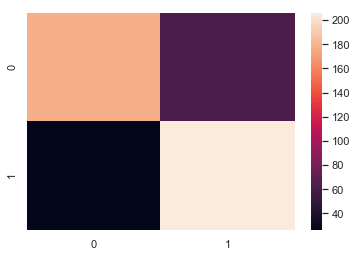

In [49]:
Run_LogisticRegression(X_train, y_train, X_test, y_test)

# Naive bayes

In [11]:
for i in str(GaussianNB().__doc__).split('Parameters\n    ----------\n')[1].split('\n\n    Attributes\n')[0].replace('\n        ', '\n').splitlines():
    if " : " in i: 
        print(i)
        
def Run_NaiveBayes(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Logistic Regression forest")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                            labels=None,
                            sample_weight=None)
    
    sns.heatmap(heatmap_array)

    priors : array-like of shape (n_classes,)
    var_smoothing : float, default=1e-9


Logistic Regression forest
              precision    recall  f1-score   support

           0       0.97      0.29      0.44       240
           1       0.57      0.99      0.73       232

    accuracy                           0.63       472
   macro avg       0.77      0.64      0.59       472
weighted avg       0.78      0.63      0.58       472

[[ 69 171]
 [  2 230]]
0.3899999473613908


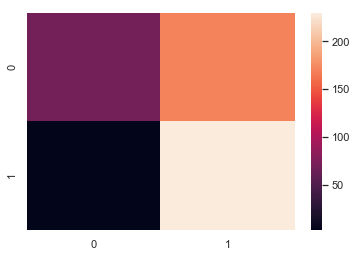

In [47]:
Run_NaiveBayes(X_train, y_train, X_test, y_test)

# Decision Tree

In [42]:
for i in str(DecisionTreeClassifier().__doc__).split('Parameters\n    ----------\n')[1].split('\n\n    Attributes\n')[0].replace('\n        ', '\n').splitlines():
    if " : " in i: 
        print(i)

def Run_decision_tree(X_train, y_train, X_test, y_test):
    parameters = {'criterion': ['gini', 'entropy'], 
                  'max_features': ['auto', 'log2']}
    
    model = DecisionTreeClassifier()
    
    clf = GridSearchCV(model, parameters, scoring=make_scorer(matthews_corrcoef))
    clf.fit(X_train, y_train)
    
    print("---Best parameters----")
    print(clf.best_params_)
    
    y_pred = clf.predict(X_test)

    print()
    print('Classification report')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                            labels=None,
                            sample_weight=None)
    
    sns.heatmap(heatmap_array)

    criterion : {"gini", "entropy"}, default="gini"
    splitter : {"best", "random"}, default="best"
    max_depth : int, default=None
    min_samples_split : int or float, default=2
    min_samples_leaf : int or float, default=1
    min_weight_fraction_leaf : float, default=0.0
    max_features : int, float or {"auto", "sqrt", "log2"}, default=None
    random_state : int, RandomState instance, default=None
    max_leaf_nodes : int, default=None
    min_impurity_decrease : float, default=0.0
    min_impurity_split : float, default=0
    class_weight : dict, list of dict or "balanced", default=None
    presort : deprecated, default='deprecated'
    ccp_alpha : non-negative float, default=0.0


---Best parameters----
{'criterion': 'entropy', 'max_features': 'auto'}

Classification report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       240
           1       0.87      0.87      0.87       232

    accuracy                           0.88       472
   macro avg       0.87      0.87      0.87       472
weighted avg       0.87      0.88      0.87       472

[[211  29]
 [ 30 202]]
0.7499169317990485


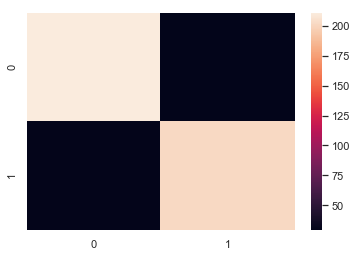

In [43]:
Run_decision_tree(X_train, y_train, X_test, y_test)

# Random Forest

In [45]:
for i in str(RandomForestClassifier().__doc__).split('Parameters\n    ----------\n')[1].split('\n\n    Attributes\n')[0].replace('\n        ', '\n').splitlines():
    if " : " in i: 
        print(i)

def Run_RF(X_train, y_train, X_test, y_test):
    parameters = {'criterion': ['gini','entropy'], 
                  'n_estimators': [50, 100, 200], 
                  'max_features': ['auto', 'log2']}
    model = RandomForestClassifier()
    
    clf = GridSearchCV(model, parameters, scoring=make_scorer(matthews_corrcoef))
    clf.fit(X_train, y_train)
    
    print("---Best parameters----")
    print(clf.best_params_)
    
    y_pred = clf.predict(X_test)

    print()
    print('Classification report')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                            labels=None,
                            sample_weight=None)
    
    sns.heatmap(heatmap_array)

    n_estimators : int, default=100
    criterion : {"gini", "entropy"}, default="gini"
    max_depth : int, default=None
    min_samples_split : int or float, default=2
    min_samples_leaf : int or float, default=1
    min_weight_fraction_leaf : float, default=0.0
    max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
    max_leaf_nodes : int, default=None
    min_impurity_decrease : float, default=0.0
    min_impurity_split : float, default=None
    bootstrap : bool, default=True
    oob_score : bool, default=False
    n_jobs : int, default=None
    random_state : int or RandomState, default=None
    verbose : int, default=0
    warm_start : bool, default=False
    class_weight : {"balanced", "balanced_subsample"}, dict or list of dicts,             default=None
    ccp_alpha : non-negative float, default=0.0
    max_samples : int or float, default=None


---Best parameters----
{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 50}

Classification report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       240
           1       0.95      0.95      0.95       232

    accuracy                           0.95       472
   macro avg       0.95      0.95      0.95       472
weighted avg       0.95      0.95      0.95       472

[[229  11]
 [ 12 220]]
0.9025154720501674


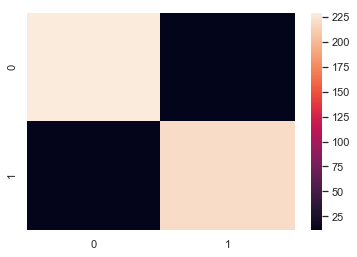

In [46]:
Run_RF(X_train, y_train, X_test, y_test)

## SVM

In [9]:
for i in str(LinearSVC().__doc__).split('Parameters\n    ----------\n')[1].split('\n\n    Attributes\n')[0].replace('\n        ', '\n').splitlines():
    if " : " in i: 
        print(i)

def Run_SVC(X_train, y_train, X_test, y_test):
    parameters = {'C': [1, 100, 1000]}
    model = LinearSVC()
    clf = GridSearchCV(model, parameters, scoring=make_scorer(matthews_corrcoef))
    clf.fit(X_train, y_train)
    
    print("---Best parameters----")
    print(clf.best_params_)
    
    y_pred = clf.predict(X_test)

    print()
    print("Support vector machine")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                            labels=None,
                            sample_weight=None)
    
    sns.heatmap(heatmap_array)

    penalty : {'l1', 'l2'}, default='l2'
    loss : {'hinge', 'squared_hinge'}, default='squared_hinge'
    dual : bool, default=True
    tol : float, default=1e-4
    C : float, default=1.0
    multi_class : {'ovr', 'crammer_singer'}, default='ovr'
    fit_intercept : bool, default=True
    intercept_scaling : float, default=1
    class_weight : dict or 'balanced', default=None
    verbose : int, default=0
    random_state : int or RandomState instance, default=None
    max_iter : int, default=1000


C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Samarth\AppData\Local\Programs\Pyth

---Best parameters----
{'C': 1}

Support vector machine
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      5939
           1       0.72      0.71      0.72      5880

    accuracy                           0.72     11819
   macro avg       0.72      0.72      0.72     11819
weighted avg       0.72      0.72      0.72     11819

[[4322 1617]
 [1693 4187]]
0.43987139392267915


C:\Users\Samarth\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


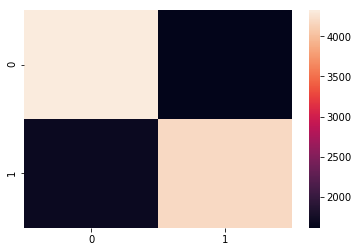

In [12]:
Run_SVC(X_train, y_train, X_test, y_test)

# KNN

In [51]:
for i in str(KNeighborsClassifier().__doc__).split('Parameters\n    ----------\n')[1].split('\n\n    Attributes\n')[0].replace('\n        ', '\n').splitlines():
    if " : " in i: 
        print(i)

def Run_KNN(X_train, y_train, X_test, y_test):
    parameters = {'weights': ['uniform', 'distance'], 
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size': [10, 100]}
    model = KNeighborsClassifier()
    clf = GridSearchCV(model, parameters, scoring=make_scorer(matthews_corrcoef))
    clf.fit(X_train, y_train)
    
    print("---Best parameters----")
    print(clf.best_params_)
    
    y_pred = clf.predict(X_test)

    print()
    print("Support vector machine")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                            labels=None,
                            sample_weight=None)
    
    sns.heatmap(heatmap_array)

    n_neighbors : int, default=5
    weights : {'uniform', 'distance'} or callable, default='uniform'
- 'uniform' : uniform weights.  All points in each neighborhood
- 'distance' : weight points by the inverse of their distance.
- [callable] : a user-defined function which accepts an
    algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
    leaf_size : int, default=30
    p : int, default=2
    metric : str or callable, default='minkowski'
    metric_params : dict, default=None
    n_jobs : int, default=None


---Best parameters----
{'algorithm': 'auto', 'leaf_size': 10, 'weights': 'distance'}

Support vector machine
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       240
           1       0.76      1.00      0.86       232

    accuracy                           0.84       472
   macro avg       0.88      0.85      0.84       472
weighted avg       0.88      0.84      0.84       472

[[167  73]
 [  1 231]]
0.7220458940625201


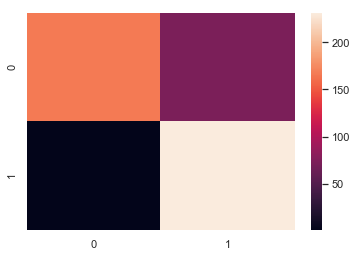

In [52]:
Run_KNN(X_train, y_train, X_test, y_test)

# XGBoost

In [ ]:
model = XGBClassifier(eta = 0.3, objective = 'binary:logistic',eval_metric = 'auc', seed = 7,reg_alpha = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))

# Bagging

In [ ]:
model = BaggingClassifier(base_estimator=AdaBoostClassifier(n_estimators=100),n_estimators=100, random_state=0).fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))

# Neural Network

In [ ]:
import keras
import numpy as np
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X_train)
sns.scatterplot(x=X_tsne[:,0],y= X_tsne[:,1],hue=y_train, legend='full', palette=sns.color_palette("bright", 2))
plt.suptitle("t-SNE")
plt.show()

dataset = loadtxt('Main_data.csv', delimiter=',')
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(1024, input_dim=48, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=100, batch_size=50)
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
y_pred = [round(x[0]) for x in predictions]
# y_pred is the predicted output vector

In [ ]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
y_pred = [round(x[0]) for x in predictions]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))

heatmap_array = metrics.confusion_matrix(y_test, y_pred,
                         labels=None,
                         sample_weight=None)
sns.heatmap(heatmap_array)

In [ ]:
weights = model.get_weights()
# function to return the features of the final hidden layer
def get_hf_features(X, n_layers, weights):

  v = []
  v.append(X)
  # calculate the features of all layers
  for i in range(n_layers-1):
    output = np.dot(v[i], weights[2*i]) + weights[2*i+1]
    x_calc = np.where(output<0,0,output)
    v.append(x_calc)
  hfs = v[-1]
# return the features of final hidden layer only
  return hfs
# call the function to get featuers of final hidden layer and plot a t-SNE plot on it
hlf = get_hf_features(X_train, 4, weights)
tsne = TSNE()
X_tsne = tsne.fit_transform(hlf)
sns.scatterplot(x=X_tsne[:,0],y= X_tsne[:,1],hue=y_train, legend='full', palette=sns.color_palette("bright", 2))
plt.suptitle("t-SNE of final hidden layer with sigmoid")
plt.show()